In [1]:
DATAPATH = '../data/'
XFERPATH = '~/downloads/'  # To transfer files from Google Colab
FNAME = 'embeds_agg.csv'

In [2]:
frompath = XFERPATH + FNAME
topath = DATAPATH + FNAME
!cp $frompath $topath

In [3]:
from importlib import reload
import lightgbm as lgb
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from utils import get_rows, balance, balanced_split_by_time_and_id

In [4]:
df = pd.read_csv(DATAPATH+FNAME,index_col=[0,1],parse_dates=['time']).drop(['text'],axis=1)
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
425472153,2019-05-25 20:24:48+00:00,Queen K,False,9156,-31075,-21194,41023,33810
1081873499621273601,2019-05-25 20:24:48+00:00,Alexandru Constantin,True,-34055,62140,-33476,1849,42774
987721418,2019-05-25 20:24:48+00:00,Susie Carmichael,False,-38618,12734,6150,6856,29976
980758839770451973,2019-05-25 20:24:52+00:00,Princess Sih.,False,-19252,-1482,-14205,-25178,-47939
838620336367218692,2019-05-25 20:24:53+00:00,Reid Kisselback,True,-40698,32644,3243,-35412,61766


In [5]:
print(df.shape)
df.index.get_level_values(1).min(), df.index.get_level_values(1).max()

(29678, 514)


(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [6]:
xy_train, xy_valid, xy_test = balanced_split_by_time_and_id(df)

X_train = xy_train.drop(['name','male'],axis=1).values
y_train = 1*xy_train.male.values

X_valid = xy_valid.drop(['name','male'],axis=1).values
y_valid = 1*xy_valid.male.values

X_test = xy_test.drop(['name','male'],axis=1).values
y_test = 1*xy_test.male.values

In [7]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['objective'] = 'binary'
params['learning_rate'] = .02
params['sub_feature'] = .4
params['lambda_l1'] = 5
params['lambda_l2'] = 1
params['max_depth'] = 5

nboost=50

reg = lgb.train(params, d_train, nboost)

In [8]:
y_train_pred = reg.predict(X_train)
f1_score(y_train, y_train_pred>.5)

0.6760728982951205

In [9]:
y_pred = reg.predict(X_valid)
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[1259  904]
 [ 840 1323]]


0.6027334851936217

In [10]:
y_test_pred = reg.predict(X_test)
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[1246  835]
 [ 794 1287]]


0.6124197002141327

In [11]:
accuracy_score(y_test, y_test_pred>.5)

0.6086016338298895

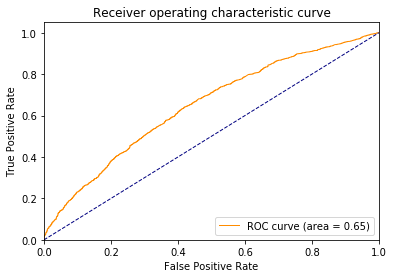

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()